### Check conda environment

In [1]:
# Check Environment
import os
print(os.environ['CONDA_DEFAULT_ENV'])

BTP2


In [2]:
# Check Python version
import sys
print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:39:05) [MSC v.1929 64 bit (AMD64)]


In [3]:
import numpy as np
print(np.__version__)

1.21.0


In [4]:
# Check Tensorflow version
import tensorflow as tf
print(tf.__version__)

2.6.0


In [5]:
# Open Gym Environment
import gym
import gym_mppt

# Check Gym Environments
from gym import envs
all_envs = envs.registry
for key, value in sorted(all_envs.items(), key=lambda x: x[0]): 
    print(key)
    
# env = gym.make('mppt_shaded-v1')

Acrobot-v1
Ant-v2
Ant-v3
Ant-v4
BipedalWalker-v3
BipedalWalkerHardcore-v3
Blackjack-v1
CarRacing-v2
CartPole-v0
CartPole-v1
CliffWalking-v0
FrozenLake-v1
FrozenLake8x8-v1
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
InvertedPendulum-v2
InvertedPendulum-v4
LunarLander-v2
LunarLanderContinuous-v2
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Pusher-v2
Pusher-v4
Reacher-v2
Reacher-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Taxi-v3
Walker2d-v2
Walker2d-v3
Walker2d-v4
mppt-v0
mppt-v1
mppt-v2
mppt_shaded-v0
mppt_shaded-v1


### Tensorflow 2 Implementation

In [6]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [7]:
problem = 'mppt_shaded-v1'
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  15.0
Min Value of Action ->  -15.0


In [8]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [9]:
class Buffer:
    def __init__(self, buffer_capacity=50000, batch_size=64):         # buffer_capacity=100000, batch_size=64
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [10]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [11]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [12]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001             # 0.001      0.002
actor_lr = 0.00001             # 0.0001     0.001
 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100       # was 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.001                  # 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -102.99554436070767
Episode * 1 * Avg Reward is ==> -101.96863305936648
Episode * 2 * Avg Reward is ==> -101.62311256751134
Episode * 3 * Avg Reward is ==> -101.40596223940615
Episode * 4 * Avg Reward is ==> -101.29286314735107
Episode * 5 * Avg Reward is ==> -101.21535614640152
Episode * 6 * Avg Reward is ==> -101.15079504803452
Episode * 7 * Avg Reward is ==> -101.10705317056944
Episode * 8 * Avg Reward is ==> -101.07728340505514
Episode * 9 * Avg Reward is ==> -101.04238416819078
Episode * 10 * Avg Reward is ==> -101.02050912762415
Episode * 11 * Avg Reward is ==> -101.00610744494213
Episode * 12 * Avg Reward is ==> -101.0003983054105
Episode * 13 * Avg Reward is ==> -100.99621368863555
Episode * 14 * Avg Reward is ==> -100.9942545511245
Episode * 15 * Avg Reward is ==> -100.99367130431123
Episode * 16 * Avg Reward is ==> [-100.93522005]
Episode * 17 * Avg Reward is ==> [-100.88326338]
Episode * 18 * Avg Reward is ==> [-100.83677584]
Episode * 19 * Av

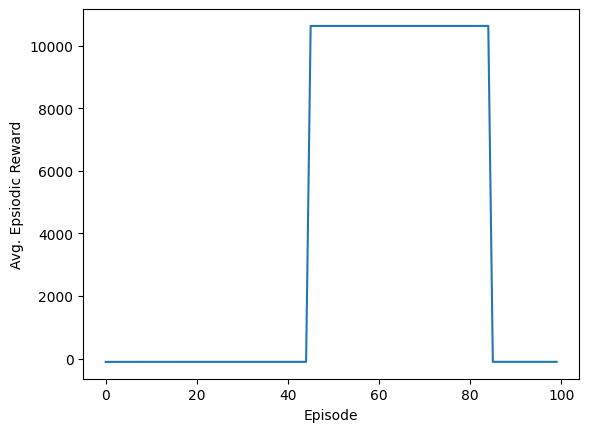

In [13]:
import warnings
warnings.filterwarnings('ignore')

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [14]:
# Save the weights
actor_model.save_weights("v2test100_actor.h5")
critic_model.save_weights("v2test100_critic.h5")

target_actor.save_weights("v2test100_target_actor.h5")
target_critic.save_weights("v2test100_target_critic.h5")

In [15]:
print(type(actor_model))

<class 'tensorflow.python.keras.engine.functional.Functional'>


In [16]:
print(actor_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 1)                 0         
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________________
None


### Simulation

[0. 0. 0.]
[array(-0.22717079)]
[array(-1.01177848)]
[array(-4.56407935)]
[array(-13.47941598)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99038082)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.98892894)]
[array(-15.)]
[array(-15.)]
[array(-14.99600263)]
[array(-14.99719214)]
[array(-15.)]
[array(-14.98116605)]
[array(-14.95837527)]
[array(-14.92171842)]
[array(-14.93261612)]
[array(-14.93624961)]
[array(-14.96029546)]
[array(-14.97512142)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99731586)]
[array(-14.98892192)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]


[array(-14.86409251)]
[array(-14.89962537)]
[array(-14.88754845)]
[array(-14.85533372)]
[array(-14.89647376)]
[array(-14.89200634)]
[array(-14.87811699)]
[array(-14.88990081)]
[array(-14.86611477)]
[array(-14.86627145)]
[array(-14.85743476)]
[array(-14.88519424)]
[array(-14.87560232)]
[array(-14.88390091)]
[array(-14.88714388)]
[array(-14.86515759)]
[array(-14.87339015)]
[array(-14.88272675)]
[array(-14.83916181)]
[array(-14.85931489)]
[array(-14.84393676)]
[array(-14.8194317)]
[array(-14.79320693)]
[array(-14.75145109)]
[array(-14.73442602)]
[array(-14.74397957)]
[array(-14.74116436)]
[array(-14.73523015)]
[array(-14.73764938)]
[array(-14.69179851)]
[array(-14.66224523)]
[array(-14.66554671)]
[array(-14.68119025)]
[array(-14.7018075)]
[array(-14.70659115)]
[array(-14.70497109)]
[array(-14.71327391)]
[array(-14.70869588)]
[array(-14.72953625)]
[array(-14.70687949)]
[array(-14.71835507)]
[array(-14.73173741)]
[array(-14.76885316)]
[array(-14.70033665)]
[array(-14.67117462)]
[array(-14.6

[array(-14.9128745)]
[array(-14.91042984)]
[array(-14.89115606)]
[array(-14.88748286)]
[array(-14.87645696)]
[array(-14.87417927)]
[array(-14.89188119)]
[array(-14.84908641)]
[array(-14.83701207)]
[array(-14.84530784)]
[array(-14.83314066)]
[array(-14.83230046)]
[array(-14.85926324)]
[array(-14.86310438)]
[array(-14.8641233)]
[array(-14.88128228)]
[array(-14.88049348)]
[array(-14.92378339)]
[array(-14.91549487)]
[array(-14.91347717)]
[array(-14.91515097)]
[array(-14.90739248)]
[array(-14.91908147)]
[array(-14.9154623)]
[array(-14.92739035)]
[array(-14.87109224)]
[array(-14.88607553)]
[array(-14.83082051)]
[array(-14.82256591)]
[array(-14.846009)]
[array(-14.85673253)]
[array(-14.86045817)]
[array(-14.86861456)]
[array(-14.85024924)]
[array(-14.87500294)]
[array(-14.88175505)]
[array(-14.8856426)]
[array(-14.87976577)]
[array(-14.88081552)]
[array(-14.90070099)]
[array(-14.87973699)]
[array(-14.89960518)]
[array(-14.91356741)]
[array(-14.89611905)]
[array(-14.89166582)]
[array(-14.88561

[array(-14.62672684)]
[array(-14.66667623)]
[array(-14.68459393)]
[array(-14.67154447)]
[array(-14.65684401)]
[array(-14.65579356)]
[array(-14.71196306)]
[array(-14.70973229)]
[array(-14.71093012)]
[array(-14.69272487)]
[array(-14.69229393)]
[array(-14.71184428)]
[array(-14.72078728)]
[array(-14.71289931)]
[array(-14.68422207)]
[array(-14.65999334)]
[array(-14.66859561)]
[array(-14.63790142)]
[array(-14.63980076)]
[array(-14.60503482)]
[array(-14.57809012)]
[array(-14.60266815)]
[array(-14.60576613)]
[array(-14.59842567)]
[array(-14.60656722)]
[array(-14.59700336)]
[array(-14.59395337)]
[array(-14.60462926)]
[array(-14.57570651)]
[array(-14.57677543)]
[array(-14.58080596)]
[array(-14.60716442)]
[array(-14.56665142)]
[array(-14.55360357)]
[array(-14.55994704)]
[array(-14.54097111)]
[array(-14.57840894)]
[array(-14.5959063)]
[array(-14.60047118)]
[array(-14.57652606)]
[array(-14.6098866)]
[array(-14.61347272)]
[array(-14.59606624)]
[array(-14.56665636)]
[array(-14.56242729)]
[array(-14.5

[array(-14.37090058)]
[array(-14.36766087)]
[array(-14.38177182)]
[array(-14.40572044)]
[array(-14.38569143)]
[array(-14.4016611)]
[array(-14.37334776)]
[array(-14.359531)]
[array(-14.39739943)]
[array(-14.38272752)]
[array(-14.37749301)]
[array(-14.34240799)]
[array(-14.34000991)]
[array(-14.34363144)]
[array(-14.31913752)]
[array(-14.34106154)]
[array(-14.32043705)]
[array(-14.30508342)]
[array(-14.30337569)]
[array(-14.32803289)]
[array(-14.31398396)]
[array(-14.28848318)]
[array(-14.28210059)]
[array(-14.29677159)]
[array(-14.30202336)]
[array(-14.31344854)]
[array(-14.32052245)]
[array(-14.32777019)]
[array(-14.32590068)]
[array(-14.31377438)]
[array(-14.28865766)]
[array(-14.25691534)]
[array(-14.26497947)]
[array(-14.25497812)]
[array(-14.24008491)]
[array(-14.23682325)]
[array(-14.23547158)]
[array(-14.28870965)]
[array(-14.2960594)]
[array(-14.30379862)]
[array(-14.30084166)]
[array(-14.3383907)]
[array(-14.35352298)]
[array(-14.3651347)]
[array(-14.34906319)]
[array(-14.36557

[array(-14.52543127)]
[array(-14.55273733)]
[array(-14.55939064)]
[array(-14.57449411)]
[array(-14.61309911)]
[array(-14.64782162)]
[array(-14.68221063)]
[array(-14.7279555)]
[array(-14.72669382)]
[array(-14.77426291)]
[array(-14.77039882)]
[array(-14.76461264)]
[array(-14.75228577)]
[array(-14.76669579)]
[array(-14.75597957)]
[array(-14.73872934)]
[array(-14.7627367)]
[array(-14.80167349)]
[array(-14.80490313)]
[array(-14.76980062)]
[array(-14.74435793)]
[array(-14.74618838)]
[array(-14.75748092)]
[array(-14.79379796)]
[array(-14.77692598)]
[array(-14.75855303)]
[array(-14.7425177)]
[array(-14.7355039)]
[array(-14.72060185)]
[array(-14.75211546)]
[array(-14.71009109)]
[array(-14.71135634)]
[array(-14.69206558)]
[array(-14.70145663)]
[array(-14.73371363)]
[array(-14.71287827)]
[array(-14.70654543)]
[array(-14.6843694)]
[array(-14.73030357)]
[array(-14.76822756)]
[array(-14.7313197)]
[array(-14.71342195)]
[array(-14.71631341)]
[array(-14.7473789)]
[array(-14.74611778)]
[array(-14.741258

[array(-14.56409891)]
[array(-14.56846653)]
[array(-14.56451983)]
[array(-14.5479595)]
[array(-14.54249474)]
[array(-14.5286254)]
[array(-14.50523325)]
[array(-14.50229639)]
[array(-14.49632933)]
[array(-14.48124988)]
[array(-14.49225692)]
[array(-14.47545464)]
[array(-14.49331489)]
[array(-14.45780086)]
[array(-14.4698676)]
[array(-14.48927413)]
[array(-14.47381262)]
[array(-14.49070477)]
[array(-14.53262112)]
[array(-14.53750018)]
[array(-14.51036412)]
[array(-14.52131153)]
[array(-14.50176498)]
[array(-14.49960251)]
[array(-14.49136863)]
[array(-14.48980149)]
[array(-14.49958891)]
[array(-14.51081332)]
[array(-14.52991922)]
[array(-14.54200634)]
[array(-14.53751549)]
[array(-14.50598006)]
[array(-14.4888013)]
[array(-14.50052514)]
[array(-14.47758348)]
[array(-14.44018107)]
[array(-14.46757986)]
[array(-14.47482493)]
[array(-14.49304857)]
[array(-14.50513667)]
[array(-14.46142929)]
[array(-14.43819338)]
[array(-14.43593859)]
[array(-14.45396945)]
[array(-14.4454977)]
[array(-14.4260

[array(-14.60903731)]
[array(-14.63563321)]
[array(-14.63924921)]
[array(-14.61007376)]
[array(-14.62921351)]
[array(-14.64994388)]
[array(-14.63648335)]
[array(-14.67838789)]
[array(-14.70025173)]
[array(-14.74202742)]
[array(-14.74336387)]
[array(-14.74811679)]
[array(-14.79056133)]
[array(-14.77792675)]
[array(-14.7863368)]
[array(-14.76488243)]
[array(-14.7949461)]
[array(-14.77722707)]
[array(-14.76071529)]
[array(-14.7853658)]
[array(-14.78227176)]
[array(-14.76527177)]
[array(-14.75392507)]
[array(-14.7706426)]
[array(-14.78847521)]
[array(-14.76689959)]
[array(-14.78344325)]
[array(-14.79335681)]
[array(-14.79772083)]
[array(-14.80641254)]
[array(-14.81231335)]
[array(-14.79721728)]
[array(-14.76634372)]
[array(-14.80658453)]
[array(-14.77953815)]
[array(-14.79945844)]
[array(-14.80280235)]
[array(-14.8050648)]
[array(-14.819449)]
[array(-14.79426128)]
[array(-14.83270399)]
[array(-14.8596085)]
[array(-14.86999948)]
[array(-14.87906599)]
[array(-14.8898882)]
[array(-14.90332044

[array(-14.38750769)]
[array(-14.40104384)]
[array(-14.4056444)]
[array(-14.43532855)]
[array(-14.40792199)]
[array(-14.37775745)]
[array(-14.37183345)]
[array(-14.41611552)]
[array(-14.42076368)]
[array(-14.39071411)]
[array(-14.35504424)]
[array(-14.39197745)]
[array(-14.36660701)]
[array(-14.36953245)]
[array(-14.37448873)]
[array(-14.38119624)]
[array(-14.41141416)]
[array(-14.41571623)]
[array(-14.40542556)]
[array(-14.39429714)]
[array(-14.40850809)]
[array(-14.40215451)]
[array(-14.3929132)]
[array(-14.38206518)]
[array(-14.36230814)]
[array(-14.35752921)]
[array(-14.39263027)]
[array(-14.41934324)]
[array(-14.42098043)]
[array(-14.42040231)]
[array(-14.42560917)]
[array(-14.46404804)]
[array(-14.40915412)]
[array(-14.44311732)]
[array(-14.45247503)]
[array(-14.43033204)]
[array(-14.43318336)]
[array(-14.44100172)]
[array(-14.42033061)]
[array(-14.43488013)]
[array(-14.40858283)]
[array(-14.41191622)]
[array(-14.39789969)]
[array(-14.37260006)]
[array(-14.37925836)]
[array(-14.3

[array(-14.62709781)]
[array(-14.62670051)]
[array(-14.60867489)]
[array(-14.63606592)]
[array(-14.65379341)]
[array(-14.65280568)]
[array(-14.63890786)]
[array(-14.63786681)]
[array(-14.65476695)]
[array(-14.64104703)]
[array(-14.64050967)]
[array(-14.63212036)]
[array(-14.66741493)]
[array(-14.66106317)]
[array(-14.6388073)]
[array(-14.6540138)]
[array(-14.6625066)]
[array(-14.67718519)]
[array(-14.69328848)]
[array(-14.6966055)]
[array(-14.70525451)]
[array(-14.69939226)]
[array(-14.69173029)]
[array(-14.6613312)]
[array(-14.64071627)]
[array(-14.66985589)]
[array(-14.66738631)]
[array(-14.64646568)]
[array(-14.66910468)]
[array(-14.66712598)]
[array(-14.68622775)]
[array(-14.67942067)]
[array(-14.66980246)]
[array(-14.66735597)]
[array(-14.68485699)]
[array(-14.67692276)]
[array(-14.65985107)]
[array(-14.68023935)]
[array(-14.67109775)]
[array(-14.66754624)]
[array(-14.67171455)]
[array(-14.66125371)]
[array(-14.68736334)]
[array(-14.68913047)]
[array(-14.69455077)]
[array(-14.6574

[array(-14.73670205)]
[array(-14.70998083)]
[array(-14.68347528)]
[array(-14.70333779)]
[array(-14.70383158)]
[array(-14.67645651)]
[array(-14.70459607)]
[array(-14.7312744)]
[array(-14.75929923)]
[array(-14.74818668)]
[array(-14.76088542)]
[array(-14.76313053)]
[array(-14.74535314)]
[array(-14.79769152)]
[array(-14.75876236)]
[array(-14.72103338)]
[array(-14.76540473)]
[array(-14.73470891)]
[array(-14.74586871)]
[array(-14.74591126)]
[array(-14.76771471)]
[array(-14.80864715)]
[array(-14.80259152)]
[array(-14.78140014)]
[array(-14.78846118)]
[array(-14.78387687)]
[array(-14.77398236)]
[array(-14.77302121)]
[array(-14.7414815)]
[array(-14.75942859)]
[array(-14.74274762)]
[array(-14.75107957)]
[array(-14.7709227)]
[array(-14.75969967)]
[array(-14.76303635)]
[array(-14.7838109)]
[array(-14.78855821)]
[array(-14.81648979)]
[array(-14.79264372)]
[array(-14.8062879)]
[array(-14.82193102)]
[array(-14.83518276)]
[array(-14.8299203)]
[array(-14.86302476)]
[array(-14.86317739)]
[array(-14.87152

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.94210256)]
[array(-14.95091768)]
[array(-14.94767857)]
[array(-14.94938028)]
[array(-14.97435168)]
[array(-14.96693101)]
[array(-14.95070386)]
[array(-14.96998962)]
[array(-14.99114282)]
[array(-15.)]
[array(-14.96588525)]
[array(-14.98401627)]
[array(-14.96908531)]
[array(-14.9696541)]
[array(-15.)]
[array(-15.)]
[array(-14.98867629)]
[array(-14.94372809)]
[array(-14.94627723)]
[array(-14.95181259)]
[array(-14.96914172)]
[array(-14.96263159)]
[array(-14.95994911)]
[array(-14.96893549)]
[array(-14.9680283)]
[array(-14.97242187)]
[array(-14.9812363)]
[array(-14.99085172)]
[array(-15.)]
[array(-14.99226352)]
[array(-14.98082257)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.98331215)]
[array(-14.99038119)]
[

[array(-14.99392674)]
[array(-14.99953942)]
[array(-14.96790661)]
[array(-14.97961931)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.98664738)]
[array(-14.98624696)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99581919)]
[array(-14.9843689)]
[array(-14.95909079)]
[array(-14.95239869)]
[array(-14.90662521)]
[array(-14.92023039)]
[array(-14.89375566)]
[array(-14.90023714)]
[array(-14.91266871)]
[array(-14.88742781)]
[array(-14.87063188)]
[array(-14.88636328)]
[array(-14.85513075)]
[array(-14.82983019)]
[array(-14.80171053)]
[array(-14.76512037)]
[array(-14.7585259)]
[array(-14.77261826)]
[array(-14.74761208)]
[array(-14.74084746)]
[array(-14.73810189)]
[array(-14.72674145)]
[array(-14.70095876)]
[array(-14.69610821)]
[array(-14.70707456)]
[array(-14.72679147)]
[array(-14.69202809)]
[array(-14.65906365)]
[array(-14.65544452)]
[array(-14.63813558)]
[array(-14.66009255)]
[array(-14.65194763)]
[array(-14.70905918)]
[array(-14.70807112)]
[array(-14.69752097)]
[array(-14.70128

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99438116)]
[array(-14.99247767)]
[array(-15.)]
[array(-15.)]
[array(-14.99577555)]
[array(-14.98572953)]
[array(-15.)]
[array(-14.99138463)]
[array(-14.98670392)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.97197408)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.9811933)]
[array(-14.97863655)]
[array(-14.98227112)]
[array(-14.96762435)]
[array(-14.9629212)]
[array(-14.99247416)]
[array(-14.99879629)]
[array(-15.)]
[array(-14.99991494)]
[array(-15.)]
[array(-15.)]
[array(-14.99562703)]
[array(-14.96723589)]
[array(-14.96829849)]
[array(-14.99576535)]
[array(-15

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99193953)]
[array(-14.98694578)]
[array(-14.95770816)]
[array(-14.94444125)]
[array(-14.93968947)]
[array(-14.95354381)]
[array(-14.93429536)]
[array(-14.94162796)]
[array(-14.96848718)]
[array(-14.94063599)]
[array(-14.94026826)]
[array(-14.968298)]
[array(-14.99270201)]
[array(-14.98729076)]
[array(-14.99879332)]


[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.99061213)]
[array(-14.9924636)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99243674)]
[array(-14.9940703)]
[array(-14.99205492)]
[array(-14.97095807)]
[array(-14.96082937)]
[array(-14.9484241)]
[array(-14.95336971)]
[array(-14.97849343)]
[array(-14.96130396)]
[array(-14.93176181)]
[array(-14.93852947)]
[array(-14.92382573)]
[array(-14.92981326)]
[array(-14.9373524)]
[array(-14.93745193)]
[array(-14.91023362)]
[array(-14.89676045)]
[array(-14.87600954)]
[array(-14.85914146)]
[array(-14.83489396)]
[array(-14.88094292)]
[array(-14.89829617)]
[array(-14.87538596)]
[array(-14.86369333)]
[array(-14.8456103)]
[array(-14.81803109)]
[array(-14.83749397)]
[array(-14.81992616)]
[array(-14.83982207)]
[array(-14.83580226)]
[array(-14.85718646)]
[array(-14.86472768)]
[array(-14.86700337)]
[array(-14.82387371)]
[array(-14.84731177)]
[array(-14.862033)]
[array(-14.84891769)]
[array(-14.83244118)]
[array(-14.8575199)]
[array(-14.84138823)]
[array(-14.85284724)]
[array

[array(-14.2490064)]
[array(-14.2776805)]
[array(-14.23720685)]
[array(-14.25082906)]
[array(-14.28429273)]
[array(-14.28995655)]
[array(-14.30043847)]
[array(-14.27964768)]
[array(-14.29970377)]
[array(-14.30765216)]
[array(-14.30817116)]
[array(-14.31884944)]
[array(-14.29073937)]
[array(-14.28472068)]
[array(-14.28640279)]
[array(-14.32106195)]
[array(-14.36122395)]
[array(-14.38281924)]
[array(-14.39684505)]
[array(-14.39216611)]
[array(-14.42881769)]
[array(-14.44447358)]
[array(-14.47045286)]
[array(-14.49192474)]
[array(-14.47373671)]
[array(-14.48527477)]
[array(-14.43555404)]
[array(-14.43033348)]
[array(-14.40637627)]
[array(-14.39611197)]
[array(-14.38918594)]
[array(-14.36883732)]
[array(-14.37270632)]
[array(-14.34402291)]
[array(-14.37550361)]
[array(-14.3824645)]
[array(-14.38344691)]
[array(-14.40929657)]
[array(-14.38380519)]
[array(-14.39998131)]
[array(-14.39355639)]
[array(-14.41169762)]
[array(-14.43646375)]
[array(-14.44496261)]
[array(-14.41223398)]
[array(-14.38

[array(-14.91208821)]
[array(-14.89993913)]
[array(-14.88257084)]
[array(-14.87839873)]
[array(-14.8687773)]
[array(-14.87016252)]
[array(-14.87530541)]
[array(-14.89995687)]
[array(-14.91017741)]
[array(-14.91117071)]
[array(-14.90038351)]
[array(-14.90945013)]
[array(-14.92116108)]
[array(-14.92688009)]
[array(-14.92301864)]
[array(-14.91184561)]
[array(-14.91574162)]
[array(-14.9458629)]
[array(-14.92220543)]
[array(-14.92192593)]
[array(-14.91158802)]
[array(-14.91338815)]
[array(-14.89892583)]
[array(-14.86799577)]
[array(-14.88193304)]
[array(-14.86740454)]
[array(-14.86686922)]
[array(-14.85854392)]
[array(-14.87180916)]
[array(-14.85879441)]
[array(-14.84735613)]
[array(-14.87363327)]
[array(-14.89563533)]
[array(-14.88831228)]
[array(-14.89351472)]
[array(-14.87705676)]
[array(-14.8818389)]
[array(-14.87679933)]
[array(-14.87551711)]
[array(-14.84177573)]
[array(-14.85522008)]
[array(-14.84849571)]
[array(-14.87310797)]
[array(-14.86915513)]
[array(-14.87769343)]
[array(-14.88

[array(-14.7580834)]
[array(-14.72249193)]
[array(-14.7024383)]
[array(-14.68467272)]
[array(-14.69734005)]
[array(-14.70089705)]
[array(-14.683429)]
[array(-14.68506583)]
[array(-14.67986183)]
[array(-14.66321922)]
[array(-14.66065623)]
[array(-14.70221473)]
[array(-14.69429099)]
[array(-14.70607091)]
[array(-14.72113269)]
[array(-14.71813112)]
[array(-14.71620355)]
[array(-14.72769881)]
[array(-14.72873955)]
[array(-14.75716768)]
[array(-14.75993065)]
[array(-14.78022464)]
[array(-14.83854133)]
[array(-14.84905691)]
[array(-14.86264331)]
[array(-14.85616232)]
[array(-14.8748605)]
[array(-14.85789202)]
[array(-14.86053598)]
[array(-14.89730349)]
[array(-14.88256864)]
[array(-14.89605733)]
[array(-14.93062736)]
[array(-14.91951245)]
[array(-14.92495145)]
[array(-14.91687128)]
[array(-14.92696576)]
[array(-14.9043598)]
[array(-14.89519318)]
[array(-14.9000243)]
[array(-14.92643247)]
[array(-14.93726231)]
[array(-14.91526709)]
[array(-14.94893694)]
[array(-14.93197851)]
[array(-14.937577

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99799205)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)

[array(-14.9501859)]
[array(-14.94775683)]
[array(-14.94097514)]
[array(-14.92562989)]
[array(-14.91453678)]
[array(-14.94322042)]
[array(-14.94464469)]
[array(-14.9217049)]
[array(-14.86244856)]
[array(-14.81421962)]
[array(-14.821885)]
[array(-14.81925133)]
[array(-14.788828)]
[array(-14.80030474)]
[array(-14.78009036)]
[array(-14.75534785)]
[array(-14.79224795)]
[array(-14.83811899)]
[array(-14.84175323)]
[array(-14.82440284)]
[array(-14.81551314)]
[array(-14.8182142)]
[array(-14.80748105)]
[array(-14.83070868)]
[array(-14.83983898)]
[array(-14.83209121)]
[array(-14.85118446)]
[array(-14.87591297)]
[array(-14.90169448)]
[array(-14.91494762)]
[array(-14.93496576)]
[array(-14.9432225)]
[array(-14.96041117)]
[array(-14.93872354)]
[array(-14.95432679)]
[array(-14.93010367)]
[array(-14.92462729)]
[array(-14.9285233)]
[array(-14.92504327)]
[array(-14.93430115)]
[array(-14.95787339)]
[array(-14.99060165)]
[array(-15.)]
[array(-15.)]
[array(-14.99882544)]
[array(-15.)]
[array(-15.)]
[array(

[array(-14.83795851)]
[array(-14.85772141)]
[array(-14.86492965)]
[array(-14.83678164)]
[array(-14.81362216)]
[array(-14.78026838)]
[array(-14.78714441)]
[array(-14.78648714)]
[array(-14.75276997)]
[array(-14.76025807)]
[array(-14.75379075)]
[array(-14.74731798)]
[array(-14.75596494)]
[array(-14.76849777)]
[array(-14.81448729)]
[array(-14.79078522)]
[array(-14.79162899)]
[array(-14.82328309)]
[array(-14.81431648)]
[array(-14.80437943)]
[array(-14.81791857)]
[array(-14.80483171)]
[array(-14.79902688)]
[array(-14.79190199)]
[array(-14.77142787)]
[array(-14.75551548)]
[array(-14.78228916)]
[array(-14.80537132)]
[array(-14.81999888)]
[array(-14.83040907)]
[array(-14.8576866)]
[array(-14.83507263)]
[array(-14.83405362)]
[array(-14.86416553)]
[array(-14.84761265)]
[array(-14.85853387)]
[array(-14.84020688)]
[array(-14.87714827)]
[array(-14.86316213)]
[array(-14.88086325)]
[array(-14.88383431)]
[array(-14.89634746)]
[array(-14.89935864)]
[array(-14.9010488)]
[array(-14.91181365)]
[array(-14.8

[array(-14.76384444)]
[array(-14.73009442)]
[array(-14.71925312)]
[array(-14.72167772)]
[array(-14.70967724)]
[array(-14.71959102)]
[array(-14.72370401)]
[array(-14.72452881)]
[array(-14.74503467)]
[array(-14.75506976)]
[array(-14.7574998)]
[array(-14.76617108)]
[array(-14.76290715)]
[array(-14.7389908)]
[array(-14.74287293)]
[array(-14.74070012)]
[array(-14.74826158)]
[array(-14.70796731)]
[array(-14.72481444)]
[array(-14.75313686)]
[array(-14.74108931)]
[array(-14.78340846)]
[array(-14.76620045)]
[array(-14.78339262)]
[array(-14.81526819)]
[array(-14.81580923)]
[array(-14.83266902)]
[array(-14.85661004)]
[array(-14.87999762)]
[array(-14.85204673)]
[array(-14.89563341)]
[array(-14.93344508)]
[array(-14.95043961)]
[array(-14.94257597)]
[array(-14.94512208)]
[array(-14.94357937)]
[array(-14.91197369)]
[array(-14.9118939)]
[array(-14.92204346)]
[array(-14.93389055)]
[array(-14.9843213)]
[array(-14.9856006)]
[array(-14.97178417)]
[array(-14.9750684)]
[array(-14.95913673)]
[array(-14.94601

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-14.96927094)]
[array(-14.96436677)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99914639)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.98425595)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[a

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.54843812)]
[array(-14.56360804)]
[array(-14.57206011)]
[array(-14.59478401)]
[array(-14.61926326)]
[array(-14.59931825)]
[array(-14.59658908)]
[array(-14.59273292)]
[array(-14.5978131)]
[array(-14.59710958)]
[array(-14.57314482)]
[array(-14.57029045)]
[array(-14.56741479)]
[array(-14.56371239)]
[array(-14.58411447)]
[array(-14.59585753)]
[array(-14.57371891)]
[array(-14.56617607)]
[array(-14.50441765)]
[array(-14.46343615)]
[array(-14.49097507)]
[array(-14.45890006)]
[array(-14.44848473)]
[array(-14.45163137)]
[array(-14.47463144)]
[array(-14.47381378)]
[array(-14.49277064)]
[array(-14.52251919)]
[array(-14.53873522)]
[array(-14.51949219)]
[array(-14.52565419)]
[array(-14.5071976)]
[array(-14.53093065)]
[array(-14.51933697)]
[array(-14.52126388)]
[array(-14.55512815)]
[array(-14.56771744)]
[array(-14.54382113)]
[array(-14.54393561)]
[array(-14.56604012)]
[array(-14.56972725)]
[array(-14.56885088)]
[array(-14.58940615)]
[array(-14.58388817)]
[array(-14.57966502)]
[array(-14.5

[array(-15.)]
[array(-14.99091156)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99227258)]
[array(-15.)]
[array(-14.96479985)]
[array(-14.95114217)]
[array(-14.96617548)]
[array(-14.98671948)]
[array(-14.9980534)]
[array(-14.9909913)]
[array(-14.94479687)]
[array(-14.96558564)]
[array(-14.95767066)]
[array(-14.99473733)]
[array(-14.98053605)]
[array(-14.9982477)]
[array(-14.99336907)]
[array(-14.97268331)]
[array(-14.97507571)]
[array(-14.99814239)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[arra

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.98602253)]
[array(-14.97099157)]
[array(-14.98234234)]
[array(-14.99684634)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[a

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.89312779)]
[array(-14.87866892)]
[array(-14.86134155)]
[array(-14.84061466)]
[array(-14.82345571)]
[array(-14.82157752)]
[array(-14.81509687)]
[array(-14.82335543)]
[array(-14.79533795)]
[array(-14.81727749)]
[array(-14.8068772)]
[array(-14.80622903)]
[array(-14.79612876)]
[array(-14.75776033)]
[array(-14.75343061)]
[array(-14.76267555)]
[array(-14.77093105)]
[array(-14.7978833)]
[array(-14.80342073)]
[array(-14.76161949)]
[array(-14.78336114)]
[array(-14.78169494)]
[array(-14.76791069)]
[array(-14.75761844)]
[array(-14.75439443)]
[array(-14.7657475)]
[array(-14.77818187)]
[array(-14.78687563)]
[array(-14.76939359)]
[array(-14.76033472)]
[array(-14.75667416)]
[array(-14.72770991)]
[array(-14.70649945)]
[array(-14.73544779)]
[array(-14.74968074)]
[array(-14.74483555)]
[array(-14.76775766)]
[array(-14.76554313)]
[array(-14.77569955)]
[array(-14.80023206)]
[array(-14.8003249)]
[array(-14.83407902)]
[array(-14.82349712)]
[array(-14.82397601)]
[array(-14.86282208)]
[array(-14.878

[array(-14.69857231)]
[array(-14.68164665)]
[array(-14.67722454)]
[array(-14.68779395)]
[array(-14.69894958)]
[array(-14.70219932)]
[array(-14.74268681)]
[array(-14.75893604)]
[array(-14.75438052)]
[array(-14.78593909)]
[array(-14.81924339)]
[array(-14.81096559)]
[array(-14.81786567)]
[array(-14.78772733)]
[array(-14.77163843)]
[array(-14.77877656)]
[array(-14.72628193)]
[array(-14.73174843)]
[array(-14.73727839)]
[array(-14.72036186)]
[array(-14.72241574)]
[array(-14.73552453)]
[array(-14.76368331)]
[array(-14.760693)]
[array(-14.7549019)]
[array(-14.76674715)]
[array(-14.75660282)]
[array(-14.75478192)]
[array(-14.7336517)]
[array(-14.71749239)]
[array(-14.71688319)]
[array(-14.75147805)]
[array(-14.73970264)]
[array(-14.7361319)]
[array(-14.71660554)]
[array(-14.72680455)]
[array(-14.74382983)]
[array(-14.76321202)]
[array(-14.800636)]
[array(-14.80443858)]
[array(-14.79315974)]
[array(-14.78743414)]
[array(-14.80749791)]
[array(-14.80286477)]
[array(-14.78676028)]
[array(-14.796479

[array(-15.)]
[array(-15.)]
[array(-14.97411111)]
[array(-14.97195872)]
[array(-14.97753125)]
[array(-15.)]
[array(-15.)]
[array(-14.97117589)]
[array(-14.95722948)]
[array(-14.95705655)]
[array(-14.94750561)]
[array(-14.94021184)]
[array(-14.86421854)]
[array(-14.87670037)]
[array(-14.85363221)]
[array(-14.86458909)]
[array(-14.84926334)]
[array(-14.8400881)]
[array(-14.84310701)]
[array(-14.87608698)]
[array(-14.8961677)]
[array(-14.89897332)]
[array(-14.88304932)]
[array(-14.88792692)]
[array(-14.89536457)]
[array(-14.85845498)]
[array(-14.90676175)]
[array(-14.9070232)]
[array(-14.91185819)]
[array(-14.90020098)]
[array(-14.90964105)]
[array(-14.90596029)]
[array(-14.90572088)]
[array(-14.90262974)]
[array(-14.89469341)]
[array(-14.85623778)]
[array(-14.83993402)]
[array(-14.85842467)]
[array(-14.84897614)]
[array(-14.84845043)]
[array(-14.87088167)]
[array(-14.87100976)]
[array(-14.8733685)]
[array(-14.87348131)]
[array(-14.84647855)]
[array(-14.87369647)]
[array(-14.88683857)]
[a

[array(-14.6581296)]
[array(-14.65753042)]
[array(-14.66545345)]
[array(-14.65862689)]
[array(-14.64975965)]
[array(-14.67146492)]
[array(-14.64793808)]
[array(-14.66428511)]
[array(-14.67643856)]
[array(-14.69427078)]
[array(-14.68207729)]
[array(-14.67416369)]
[array(-14.7020095)]
[array(-14.68130185)]
[array(-14.73044675)]
[array(-14.72973917)]
[array(-14.74328025)]
[array(-14.72869715)]
[array(-14.72093237)]
[array(-14.71807933)]
[array(-14.72179659)]
[array(-14.72234715)]
[array(-14.71136118)]
[array(-14.73687534)]
[array(-14.74153413)]
[array(-14.71923181)]
[array(-14.74020359)]
[array(-14.71384117)]
[array(-14.73667134)]
[array(-14.73059324)]
[array(-14.73304117)]
[array(-14.73679359)]
[array(-14.7427383)]
[array(-14.73428974)]
[array(-14.70247079)]
[array(-14.71260037)]
[array(-14.70922701)]
[array(-14.68528458)]
[array(-14.68630238)]
[array(-14.69354551)]
[array(-14.69221992)]
[array(-14.65065306)]
[array(-14.67090491)]
[array(-14.67381205)]
[array(-14.63804818)]
[array(-14.63

[array(-14.82129433)]
[array(-14.79960907)]
[array(-14.83386107)]
[array(-14.78617589)]
[array(-14.77741966)]
[array(-14.7901027)]
[array(-14.77897646)]
[array(-14.77083278)]
[array(-14.79704198)]
[array(-14.80924414)]
[array(-14.8543431)]
[array(-14.89211424)]
[array(-14.90683859)]
[array(-14.92661928)]
[array(-14.89971803)]
[array(-14.92719349)]
[array(-14.93218852)]
[array(-14.93884372)]
[array(-14.91738439)]
[array(-14.88841497)]
[array(-14.90204186)]
[array(-14.88163088)]
[array(-14.92712337)]
[array(-14.91971724)]
[array(-14.89922426)]
[array(-14.91831224)]
[array(-14.97190417)]
[array(-14.96868008)]
[array(-14.95862265)]
[array(-14.96335706)]
[array(-14.99615749)]
[array(-14.97665519)]
[array(-14.98272796)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99988665)]
[array(-15.)]
[array(-14.97682329)]
[array(-14.98280551)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.98521833)]
[array(-14.98662022)]
[array(-15.)

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.96702187)]
[array(-14.93467266)]
[array(-14.94934437)]
[array(-14.951454)]
[array(-14.95747287)]
[array(-14.96673407)]
[array(-14.98508733)]
[array(-14.99442835)]
[array(-14.95842415)]
[array(-14.95951165)]
[array(-14.94952646)]
[array(-14.96909997)]
[array(-14.96519785)]
[array(-14.98272484)]
[array(-14.98689818)]
[array(-14.96246888)]
[array(-14.93277527)]
[array(-14.93982484)]
[array(-14.92718952)]
[array(-14.96104939)]
[array(-14.97115615)]
[array(-14.95194438)]
[array(-14.95270259)]
[array(-14.95707582)]
[array(-14.96244745)]
[array(-14.96184347)]
[array(-14.94144874)]
[array(-14.92891511)]
[array(-14.92759325)]
[array(-14.9061124)]
[array(-14.91933582)]
[array(-14.92155636)]
[array(-14.90896597)]
[array(-14.9591462)]
[array(-14.94143193)]
[array(-14.97891049)]
[array(-14.98008419)]
[array(-14.99201666)]
[array(-14.96051184)]
[array(-14.9682005)]
[array(-14.93963908)]
[array(-14.9557872)]
[array(-14.97520241)]
[array(-14.99838674)]
[array(-15.)]
[array(-15.)]
[array(-15

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-14.82185609)]
[array(-14.80424567)]
[array(-14.80702879)]
[array(-14.80911719)]
[array(-14.83927953)]
[array(-14.8762524)]
[array(-14.84924572)]
[array(-14.84282926)]
[array(-14.85447613)]
[array(-14.83926302)]
[array(-14.86075808)]
[array(-14.85530921)]
[array(-14.86697513)]
[array(-14.89336129)]
[array(-14.91236582)]
[array(-14.90791853)]
[array(-14.91164133)]
[array(-14.91616619)]
[array(-14.91678632)]
[array(-14.91692652)]
[array(-14.91339067)]
[array(-14.89360228)]
[array(-14.86833511)]
[array(-14.85557316)]
[array(-14.88302055)]
[array(-14.85722358)]
[array(-14.85194375)]
[array(-14.87305309)]
[array(-14.88485094)]
[array(-14.89652615)]
[array(-14.8845828)]
[array(-14.91438982)]
[array(-14.90399878)]
[array(-14.88701171)]
[array(-14.86601602)]
[array(-14.90023487)]
[array(-14.95985048)]
[array(-14.9786182)]
[array(-14.98290253)]
[array(-14.99382115)]
[array(-14.98907829)]
[array(-14.96878339)]
[array(-14.96547491)]
[array(-14.97601857)]
[array(-14.99333961)]
[array(-14.96

[array(-14.93859694)]
[array(-14.95019401)]
[array(-14.98767197)]
[array(-14.99117174)]
[array(-14.97862596)]
[array(-14.96769643)]
[array(-14.97371125)]
[array(-14.96055089)]
[array(-14.99294094)]
[array(-15.)]
[array(-14.9829036)]
[array(-14.99614311)]
[array(-15.)]
[array(-14.97014745)]
[array(-14.98442076)]
[array(-14.97638809)]
[array(-14.95659363)]
[array(-14.96762147)]
[array(-14.95239827)]
[array(-14.95905128)]
[array(-14.9576419)]
[array(-14.94583614)]
[array(-14.96002702)]
[array(-14.9365685)]
[array(-14.94193437)]
[array(-14.96823295)]
[array(-14.95197062)]
[array(-14.94448561)]
[array(-14.92953609)]
[array(-14.93954002)]
[array(-14.94329347)]
[array(-14.93032295)]
[array(-14.93299716)]
[array(-14.94111034)]
[array(-14.92326686)]
[array(-14.92490822)]
[array(-14.9574619)]
[array(-14.9828037)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[ar

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-14.99411181)]
[array(-14.99691487)]
[array(-14.98022175)]
[array(-14.96757001)]
[array(-14.99555818)]
[array(-14.97753885)]
[array(-14.98992153)]
[array(-14.99539502)]
[array(-14.93753569)]
[array(-14.94836118)]
[array(-14.92700745)]
[array(-14.93582219)]
[array(-14.93035979)]
[array(-14.98452051)]
[array(-14.93771052)]
[array(-14.96827338)]
[array(-14.9742662

[array(-14.70374831)]
[array(-14.72726035)]
[array(-14.75195896)]
[array(-14.76686267)]
[array(-14.77454593)]
[array(-14.75748669)]
[array(-14.75776868)]
[array(-14.76603581)]
[array(-14.74415694)]
[array(-14.72597324)]
[array(-14.71133743)]
[array(-14.71886642)]
[array(-14.73525138)]
[array(-14.73111729)]
[array(-14.74581372)]
[array(-14.73362981)]
[array(-14.74120586)]
[array(-14.7255366)]
[array(-14.72094376)]
[array(-14.70942041)]
[array(-14.72475565)]
[array(-14.72168645)]
[array(-14.73766719)]
[array(-14.75012557)]
[array(-14.75709363)]
[array(-14.75776282)]
[array(-14.80007228)]
[array(-14.79279547)]
[array(-14.76346363)]
[array(-14.768304)]
[array(-14.77636928)]
[array(-14.80969964)]
[array(-14.81546358)]
[array(-14.81844615)]
[array(-14.79230636)]
[array(-14.78955441)]
[array(-14.84315545)]
[array(-14.8341999)]
[array(-14.8464547)]
[array(-14.83687704)]
[array(-14.81583117)]
[array(-14.804767)]
[array(-14.79800003)]
[array(-14.80374974)]
[array(-14.82793994)]
[array(-14.850056

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array(-15.)]
[array

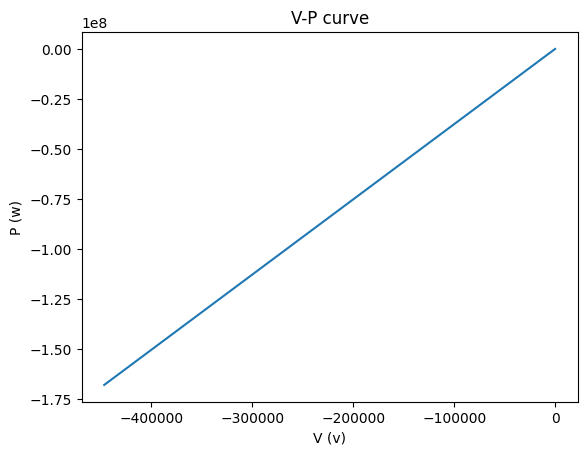

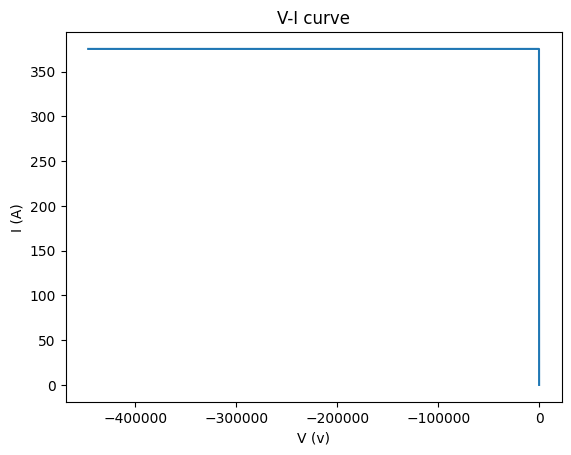

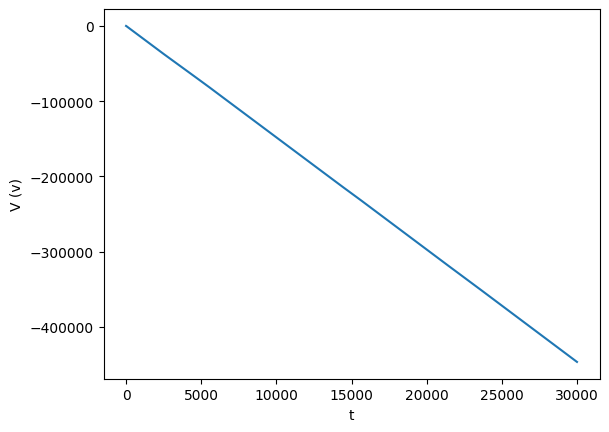

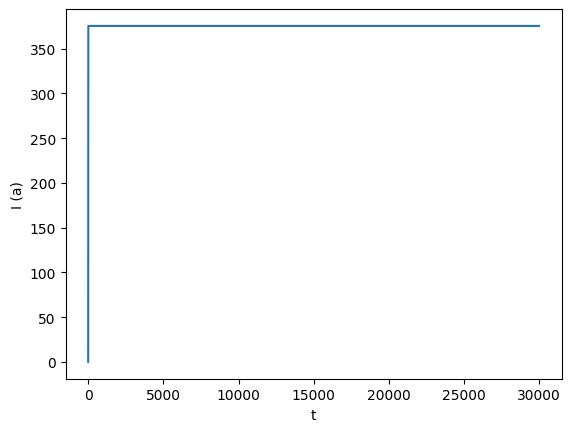

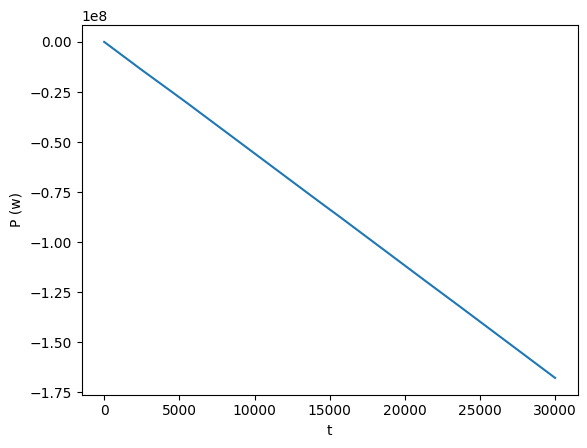

ValueError: setting an array element with a sequence.

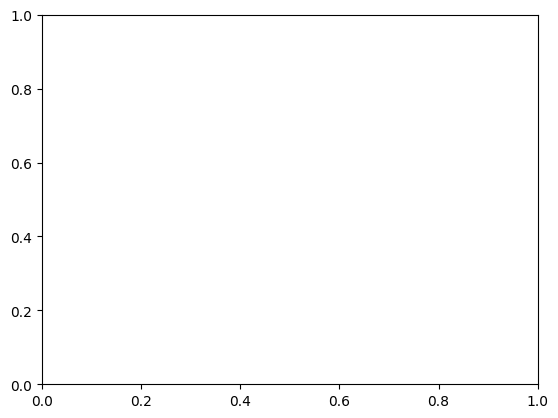

In [17]:
%run Graphs.ipynb

observation = env.reset()
print(observation)

irradiances = list([1000., 1000., 1000.])
temperatures = list([25., 25., 25.,])
# [a, 10, b, 10, c, 10]
sh = list([[2, 10, 10, 10, 7, 10],[9, 10, 3, 10, 6, 10],[5, 10, 9, 10, 10, 10]])

max_steps = 10000
# min_action = -5.
# max_action = 5.
 
observation = env.setTempIrr(observation, temperatures[0], irradiances[0], sh[0])
data = DATA(observation, temperatures[0], irradiances[0])

for i in range(len(temperatures)):
    #observation =  env.reset()
    env.setTempIrr(observation, temperatures[i], irradiances[i], sh[i])
    
    for j in range(max_steps):
        tf_observation = tf.expand_dims(tf.convert_to_tensor(observation), 0)    
        action = policy(tf_observation, ou_noise)
#         action = np.clip(action,min_action,max_action)
        print(action)
        
        observation, reward, done, info = env.step(action)
        data.add(observation[0], observation[1], observation[2], info['Corriente'], info['Temperatura'], info['Irradiancia'], info['Accion'])

data.plotear()

In [ ]:
Pmax = np.max(powerlst)
Pfinal = (powerlst[-2] + powerlst[-1])/2
DeltaP = 100 - (Pfinal/Pmax*100)

print('Pmax   = ', Pmax)
print('Pfinal = ', Pfinal)
print('DeltaP = ', DeltaP, " %")